# The Solow Model with productive externalities

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
import sympy as sm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import interact, FloatSlider
import pandas as pd  # Import pandas library

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Import our class
from modelproject import modelprojectclass

# We now define our model 
model = modelprojectclass()

par = model.par

# Model description

The model is described as:

1. $K_t$ is capital
2. $L_t$ is labor (growing with a constant rate of $n$)
3. $A_t$ is technology (growing with a constant rate of $g$)
4. $Y_t = F(K_t,A_tL_t)$ is GDP

**GDP** is given as
$$ 
Y_t = K_t^\alpha(A_t L_t)^{1-\alpha}, \alpha > 0
$$

The **production function** has **constant-return to scale**

**Saving** is a constant fraction of GDP
$$ 
S_t = sY_t,\,s\in(0,1)
$$

such that **capital accumulates** according to

$$
K_{t+1}=S_{t}+(1-\delta)K_{t}, \delta\in(0,1)
$$

**Labor** is assumed to be the whole population
$$
L_{t+1}=(1 + n) L_t, n \geq 0
$$

**Technology** is described as
$$
A_{t+1}= K_t^\phi, \phi > 0
$$

The **techonology** function is what distinguish this model from a normal Solow Model, since this function assumes productive externalities from capital.



## The Steady State

As mentioned previosly, if $\phi = 0$, then the model above is just the basic Solow model. We will therefore assume $\phi < 1$, and there will therefore be diminishing return to capital alone. This means that $A_t$ is not growing at an exogenous rate, but instead it is enodgenous and depends on $K_t$ and how it evolves. 

We want to find the steady state function, we therefore use **sympy** to find an analytical expression for the steady state, i.e. we solve the transition equation for $k_t$ (where $k_t = \frac{K_t} {A_t L_t}$):
$$
k_{t+1} = \frac{1}{(1+n)} k_t[sk_{t}^{\alpha-1}+(1-\delta)]^{1-\phi}
$$

The small letters represents per effective worker. 

Since we have assumed that $\phi < 1$ the equation above is well defined and positive. Also notice that if $\phi = 0$ we will get something equivalent to the transition equation of the basic Solow Model.

In [3]:
# We start out by defining the symbols
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
phi = sm.symbols('phi')
s = sm.symbols('s')
n = sm.symbols('n')
k = sm.symbols('k')

In [4]:
# In order to find an analytical expression for the steady state, we need to solve for k in the transition equation
ss = sm.Eq(k, (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi))

# We solve ss for k and the print the steady state function
kss = sm.solve(ss,k)[1]
kss

((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1))

In [5]:
# Since we want to find a numerical steady state we simulate with these parameter values
paramter_values = {'Parameter': ["s", "n", "delta", "alpha", "phi"],'Value': [par.s, par.n, par.delta, par.alpha, par.phi]}
df = pd.DataFrame(paramter_values)
print(df)

  Parameter  Value
0         s   0.30
1         n   0.02
2     delta   0.05
3     alpha   0.33
4       phi   0.50


In [6]:
# We turn the solution into a python function
ss_func = sm.lambdify((s,n,delta,alpha,phi),kss)

# We assign values for the parameters and print the numerical steady state value for k, given the parameters
print('The steady state, k* = ',ss_func(par.s,par.n,par.delta,par.alpha,par.phi))

The steady state, k* =  5.991582294300367


We can also show the steady state in a transition diagram, where the steady state will be the intersection between a 45 degree line and the transition line.

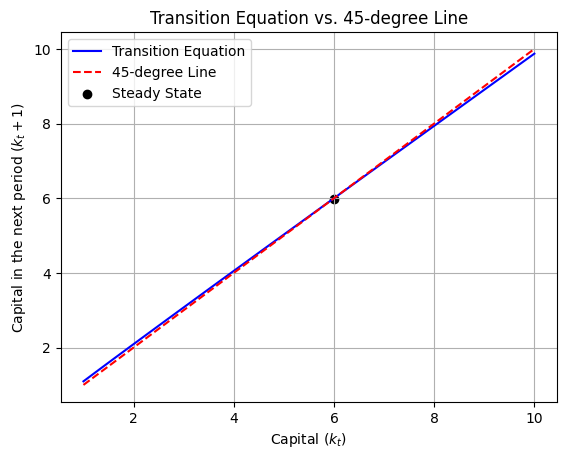

In [7]:
# Define the transition equation
def transition_equation(k, s, alpha, delta, n, phi):
    return (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)

# Define the 45-degree line
def forty_five_degree_line(k):
    return k

# Define the function to find the intersection point
def find_intersection(s, alpha, delta, n, phi):
    intersection_func = lambda k: transition_equation(k, s, alpha, delta, n, phi) - forty_five_degree_line(k)
    k_intersect = fsolve(intersection_func, 5)  # Starting guess for k
    investment_intersect = transition_equation(k_intersect, s, alpha, delta, n, phi)
    return k_intersect[0], investment_intersect[0]

# Generate a range of k values
k_values = np.linspace(1, 10, 100)

# Calculate corresponding values for the transition equation and 45-degree line
transition_values = transition_equation(k_values, par.s, par.alpha, par.delta, par.n, par.phi)
forty_five_degree_values = forty_five_degree_line(k_values)

# Find the intersection point
k_intersect, investment_intersect = find_intersection(par.s, par.alpha, par.delta, par.n, par.phi)

# Plotting
plt.plot(k_values, transition_values, label='Transition Equation', color='blue')
plt.plot(k_values, forty_five_degree_values, label='45-degree Line', linestyle='--', color='red')
plt.scatter(k_intersect, investment_intersect, color='black', label='Steady State')

plt.title('Transition Equation vs. 45-degree Line')
plt.xlabel('Capital ($k_t$)')
plt.ylabel('Capital in the next period ($k_t+1$)')
plt.legend()
plt.grid(True)
plt.show()

In this graph, we can see that the transition line crosses the 45-degree line. At this point, we find the steady-state value for the given parameters, meaning capital will not increase per effective worker. The reason for this is the depreciation of capital. As the level of capital increases, a higher numerical value of capital will be destroyed.

## Parameter calibrations

We would now like to look at how the model is affected by the different parameters, in order to see how sensitive the model is for value changes (in case of wrongly calibrate parameter values). 

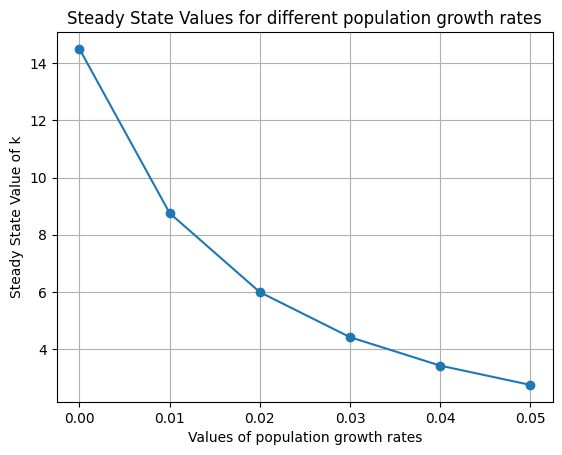

In [8]:
# We create a list for different values of n, so we can see how it effects the steady state
n_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for n in n_values:
    obj_kss = lambda k: k - transition_equation(k, par.s, par.alpha, par.delta, n, par.phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(n_values, steady_states, marker='o')
plt.title('Steady State Values for different population growth rates')
plt.xlabel('Values of population growth rates')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

In this graph we can see the steady state value of k becomes smaller when there is more population growth. This is because of thinning of capital, since more workers are splitting the capital. 

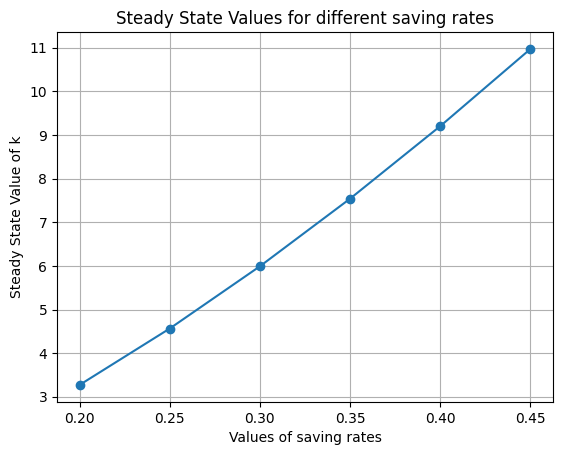

In [9]:
# We create a list for different values of s, so we can see how it effects the steady state
s_values = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for s in s_values:
    obj_kss = lambda k: k - transition_equation(k, s, par.alpha, par.delta, par.n, par.phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(s_values, steady_states, marker='o')
plt.title('Steady State Values for different saving rates')
plt.xlabel('Values of saving rates')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

In this graph we see the values for saving rates and the steady state for capital. We can see when saving rates grows the capital also goes up. In this model we are in a closed-economy which means savings = capital and therefore the result is not surprising.

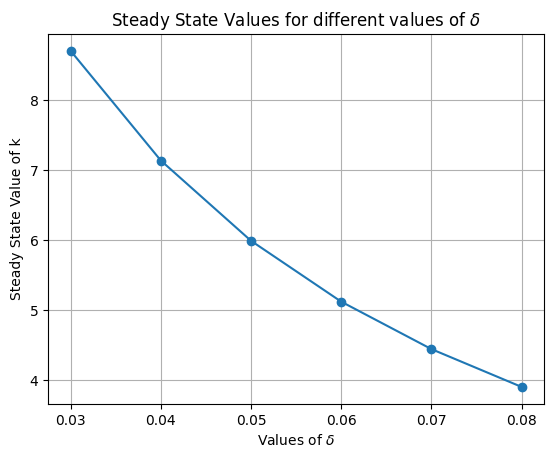

In [10]:
# We create a list for different values of delta, so we can see how it effects the steady state
delta_values = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for delta in delta_values:
    obj_kss = lambda k: k - transition_equation(k, par.s, par.alpha, delta, par.n, par.phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(delta_values, steady_states, marker='o')
plt.title('Steady State Values for different values of $\delta$')
plt.xlabel('Values of $\delta$')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

This graph shows the steady state values of k when changing values for capital depreciation. We can see when the values of $\delta$ increases the steady state value drops. This is because a bigger part of the captial will be destroyed each year, so there will be a smaller amount of capital in the steady state. 

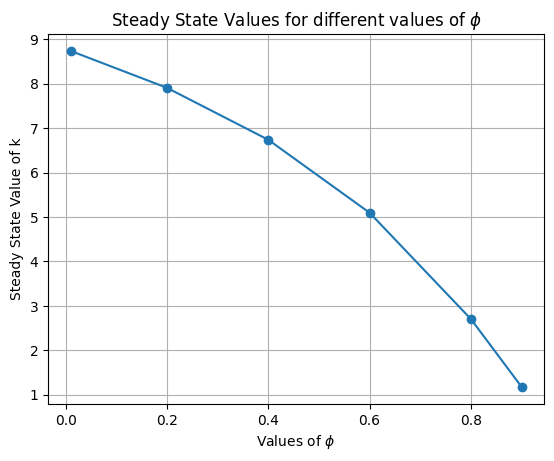

In [11]:
# We create a list for different values of delta, so we can see how it effects the steady state
phi_values = [0.01, 0.2, 0.4, 0.6, 0.8, 0.9]

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for phi in phi_values:
    obj_kss = lambda k: k - transition_equation(k, par.s, par.alpha, par.delta, par.n, phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(phi_values, steady_states, marker='o')
plt.title('Steady State Values for different values of $\phi$')
plt.xlabel('Values of $\phi$')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

The graph shows that when $\phi$ increases, the steady state value of capital decreases. This makes sence when we look our steady state function, however intuitively it does not really make sense. In the equations for our model, we can see that $A_{t+1}$ increases when $\phi$ increases, this would effect $Y_t$ positively, which should result in the opposite of what the graph shows us (which would be increasing steady state value of capital when $\phi$ increases). We have not been able to solve the problem, however this could indicate that our steady state function is wrong.

For the fun of it, we are going to plot an interactive plot, where we will make three different sliders: one for savings rates, one for depreciation of capital ($\delta$) and one for how strongly the endogenous growth in productivity from capital is ($\phi$).

In [12]:
# Define a function to calculate steady state for given parameters
def calculate_steady_state(s, alpha, delta, n, phi):
    steady_states = []
    n_values = np.linspace(0, 0.05, 100)
    for n in n_values:
        obj_kss = lambda k: k - transition_equation(k, s, alpha, delta, n, phi)
        result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
        steady_states.append(result.root)
    return n_values, steady_states

# Create interactive plot
def interactive_plot(s=0.3, delta=0.05, phi=0.5):
    alpha = 0.33  # Setting a default value for alpha
    n_values, steady_states = calculate_steady_state(s, alpha, delta, n, phi)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=n_values, y=steady_states, mode='lines+markers', name='Steady State Values'))
    fig.update_layout(
        title='Steady State Values for different population growth rates',
        xaxis=dict(title='Values of population growth rates'),
        yaxis=dict(title='Steady State Value of k'),
        hovermode='x unified',
        template='plotly_white'
    )
    fig.show()

# Define sliders for parameters
s_slider = FloatSlider(value=0.3, min=0.1, max=0.6, step=0.01, description='s:')
delta_slider = FloatSlider(value=0.05, min=0, max=0.1, step=0.01, description='delta:')
phi_slider = FloatSlider(value=0.5, min=0.05, max=0.9, step=0.01, description='phi:')

# Create interactive plot
interact(interactive_plot, s=s_slider, delta=delta_slider, phi=phi_slider)

# The first plot is the steady state values for the baseline parameters, and the second one is the interactive plot

interactive(children=(FloatSlider(value=0.3, description='s:', max=0.6, min=0.1, step=0.01), FloatSlider(value…

<function __main__.interactive_plot(s=0.3, delta=0.05, phi=0.5)>

# The AK-model

We would now change the semi-endogenous model to an endogenous mode, this means that we set $\phi = 1$ and assume no population growth, which means that $n = 0$. The equations are the same as before, except $L_t$ and $A_{t+1}$.

**GDP** is now given as
$$ 
Y_t = K_t^\alpha(A_t L)^{1-\alpha}, \alpha > 0
$$

**Saving** is still a constant fraction of GDP
$$ 
S_t = sY_t,\,s\in(0,1)
$$

such that **capital accumulates** according to

$$
K_{t+1}=S_{t}+(1-\delta)K_{t}, \delta\in(0,1)
$$

**Labor** is now assumed to be the whole population the year prior
$$
L_{t+1} = L_t = L
$$

**Technology** is now described as
$$
A_{t+1}= K_t
$$

We want to find the steady state function by using the same method as previously, i.e. we would like to solve the transition equation for $k_t$:
$$
k_{t+1} = s k_t L^{1-\alpha}+(1-\delta)k_t
$$



In [13]:
print(par.s)
print(par.alpha)
print(par.delta)
print(par.L)

0.3
0.33
0.05
1


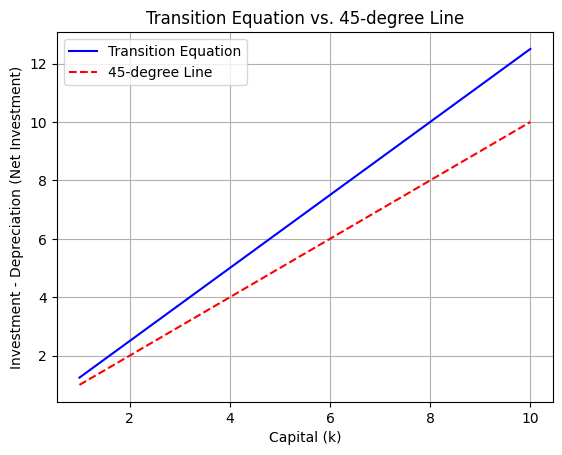

In [14]:
# We define the transition equation
def new_transition_equation(k, s, alpha, delta, L):
    return (s*k*L**(1-alpha)+(1-delta)*k)

# Generate a range of k values
k_values = np.linspace(1, 10, 100)

# Calculate corresponding values for the transition equation and 45-degree line
transition_values = new_transition_equation(k_values, par.s, par.alpha, par.delta, par.L)
forty_five_degree_values = forty_five_degree_line(k_values)

# Plotting
plt.plot(k_values, transition_values, label='Transition Equation', color='blue')
plt.plot(k_values, forty_five_degree_values, label='45-degree Line', linestyle='--', color='red')

# Labeling and customization
plt.title('Transition Equation vs. 45-degree Line')
plt.xlabel('Capital (k)')
plt.ylabel('Investment - Depreciation (Net Investment)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Create a DataFrame to display k values and transition values
data = {
    'k_values': k_values,
}

df = pd.DataFrame(data)

# Print the table
print(df)  # Display the entire DataFrame if needed

     k_values
0    1.000000
1    1.090909
2    1.181818
3    1.272727
4    1.363636
..        ...
95   9.636364
96   9.727273
97   9.818182
98   9.909091
99  10.000000

[100 rows x 1 columns]


By plotting the transition equation in relation to the 45 degree line we can see that the two lines do not cross eachother. This means that the inada conditions are not satisfied. However in the list above we can see capital evolves lineary and becomes 0.090909 higher every year. In our model we can then see that A evolves the same way as k. L do not evolve and we therefore get lineary growth. This is therefore steady state since the growth don't change.  

# Conclusion

In the Solow model with semi-endogenous growth, we estimate the steady state values and change the values for the different parameters to see how it effects the steady state values. We find that increasing population growth ($n$), increasing endogenous growth in productivity from capital ($\phi$) and higher depreciation rates of capital ($\delta$) lowers the steady state value. On the other hand, we find that higher saving rates ($s$) effects the steady values positively. For the extenstion of the model, we set up an AK model (Solow model with endogenous growth), in here we solve for the steady state values, as the structurel parameters evolves lineary. 